In [0]:
# Import the stuff that'll be needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import rankdata
from scipy import sparse
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import gc


In [0]:
#Load data from gitHub
url = 'https://raw.githubusercontent.com/NolangerAtEase/QuizBowlStuff/master/QuestionClassifiers/data/questions_Reclassified.csv'
qb = pd.read_csv(url, header = 0)# Dataset is now stored in a Pandas 
# Reset indices to make it easier to train/test split later
qb = qb.reset_index()

qb.tail()

,index,Unnamed: 0,Question.ID,Fold,Answer,Category,Class,SubClass,IncompFlg,Text,Unnamed: 9
20402,20402,11450,115645,test,The Charterhouse of Parma,Literature,Lit,NaN,NaN,The author's forward to this novel explains it...,1388
20403,20403,9166,115563,train,Lyrical Ballads,Literature,Lit,NaN,NaN,William Hazlitt compared sections of this work...,1409
20404,20404,4588,115647,train,Jameson Raid,History,Hist,NaN,NaN,One reaction to this event was allegedly the s...,1441
20405,20405,6287,115572,test,John Foster Dulles,History,Hist,NaN,NaN,A Supreme Court case with this man as the name...,1474
20406,20406,14772,116117,train,Wittig reaction,Science:Chemistry,Sci,Chem,NaN,An intermolecular aza-variation of this reacti...,1566


In [0]:
#Filter out Trash questions and incomplete questions
qb = qb[qb['IncompFlg'] != 1]
qb = qb[qb['Class'] != "Trash"]
qb = qb.reset_index()
qb.tail()

,level_0,index,Unnamed: 0,Question.ID,Fold,Answer,Category,Class,SubClass,IncompFlg,Text,Unnamed: 9
20157,20402,20402,11450,115645,test,The Charterhouse of Parma,Literature,Lit,NaN,NaN,The author's forward to this novel explains it...,1388
20158,20403,20403,9166,115563,train,Lyrical Ballads,Literature,Lit,NaN,NaN,William Hazlitt compared sections of this work...,1409
20159,20404,20404,4588,115647,train,Jameson Raid,History,Hist,NaN,NaN,One reaction to this event was allegedly the s...,1441
20160,20405,20405,6287,115572,test,John Foster Dulles,History,Hist,NaN,NaN,A Supreme Court case with this man as the name...,1474
20161,20406,20406,14772,116117,train,Wittig reaction,Science:Chemistry,Sci,Chem,NaN,An intermolecular aza-variation of this reacti...,1566


In [0]:
#Test/Train split
X = qb['Text']
y = qb['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

print(len(X_train), len(X_test), len(y_train), len(y_test))

15121 5041 15121 5041


In [0]:
#Use tf-idf vectorizer (or Countvectorizer) on whole data

vectorizer = TfidfVectorizer(min_df = 1, stop_words = 'english')
dtm_whole = vectorizer.fit_transform(X)


In [0]:
# subset the dtm into traindtm and test dtm

train_indices = [i for i in X_train.index.values]
test_indices = [i for i in X_test.index.values]

dtm_train = dtm_whole[[i for i in train_indices]]
dtm_test = dtm_whole[[i for i in test_indices]]

In [0]:
#Run the svd and lsa on training dtm

svd = TruncatedSVD(100, algorithm = 'randomized')
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
dtm_train_lsa = lsa.fit_transform(dtm_train)
dtm_test_lsa = lsa.transform(dtm_test)

['FA' 'Geo' 'Hist' 'Lit' 'Myth' 'Philo' 'Religion' 'SS' 'Sci']
[8 3 1 ... 0 3 3]


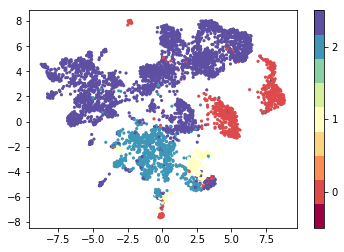

In [0]:
import umap

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_test)
LabelEncoder()

embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(dtm_test_lsa)


print(le.classes_)
print(le.transform(y_test))

plt.scatter(embedding[:, 0], embedding[:, 1], 
c = le.transform(y_test),
cmap = plt.cm.get_cmap('Spectral', 9),
s = 10, # size
edgecolor='none'
)


formatter = plt.FuncFormatter(lambda val, loc: le.transform(y_test)[val])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8])#, format=formatter);
plt.clim(-0.5, 2.5)

plt.show()

TypeError: ignored

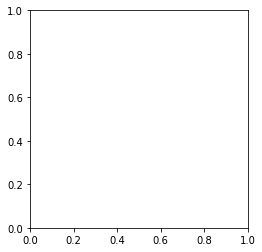

In [0]:
plt.imshow(svd, cmap='hot', interpolation='nearest')
plt.show()

In [0]:
#Just for giggles and as a sanity check, look at some of the components
# Note: doesn't work if the svd was done using fit_transform as above
terms = vectorizer.get_feature_names()
for i, comp in enumerate(svd.fit(dtm_train).components_[:10]):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
author
 
work
 
man
 
novel
 
character
 
wrote
 
title
 
Topic 1: 
quantity
 
country
 
equation
 
equal
 
reaction
 
times
 
used
 
Topic 2: 
country
 
war
 
battle
 
city
 
nation
 
led
 
capital
 
Topic 3: 
composer
 
symphony
 
movement
 
work
 
man
 
painting
 
works
 
Topic 4: 
country
 
composer
 
wrote
 
author
 
poem
 
quantity
 
symphony
 
Topic 5: 
composer
 
character
 
novel
 
protagonist
 
opera
 
symphony
 
movement
 
Topic 6: 
reaction
 
element
 
compounds
 
compound
 
process
 
used
 
acid
 
Topic 7: 
country
 
painting
 
artist
 
painted
 
work
 
figure
 
painter
 
Topic 8: 
poem
 
god
 
character
 
poet
 
title
 
speaker
 
play
 
Topic 9: 
god
 
deity
 
son
 
goddess
 
story
 
figure
 
father
 


In [0]:
#Run a logistic regression classifier on lsa-ed data and predict test set
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 1000, verbose = 3).fit(dtm_train_lsa, y_train)

preds_Train = clf.predict(dtm_train_lsa)
preds_Test = clf.predict(dtm_test_lsa)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


In [0]:
#Run a multinomial Naive Bayes classifier on non-lsa-ed dat and predict test set
#n_terms = [1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]

#train_accs_mnb = []
#test_accs_mnb = []

#for i in n_terms:
mnb = MultinomialNB()
model = mnb.fit(dtm_train_lsa, y_train)
  

preds_Train_mnb = mnb.predict(dtm_train)
preds_Test_mnb = mnb.predict(dtm_test)

print(accuracy_score(preds_Train_mnb, y_train))

ValueError: ignored

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[0.2669796971099795, 0.8376430130282388, 0.9130348521923153, 0.9353217379802923, 0.9525825011573309, 0.9575424905760201, 0.962039547648965, 0.9709013954103565, 0.974935520137557, 0.9772501818662787, 0.9781760465577674]
[0.2620511803213648, 0.8341598889109304, 0.9061694108311843, 0.9339416782384448, 0.9490180519738147, 0.9551676254711366, 0.9553659988097599, 0.9625074390001984, 0.9646895457250545, 0.9666732791112874, 0.9660781590954176]


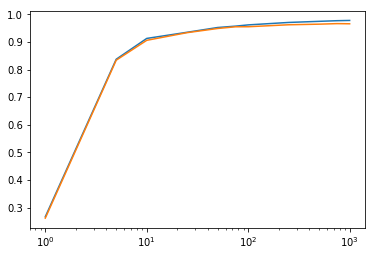

In [0]:
n_terms = [1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000]

train_accs_lsa = []
test_accs_lsa = []

#print(type(test_accs))
for i in n_terms:
  #ch2 = SelectKBest(chi2, k= i)
  
  svd = TruncatedSVD(i, algorithm = 'randomized')
  lsa = make_pipeline(svd, Normalizer(copy=False))

  dtm_train_lsa = lsa.fit_transform(dtm_train)
  dtm_test_lsa = lsa.transform(dtm_test) 
  clf_lsa = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 1000, verbose = 3).fit(dtm_train_lsa, y_train)
  preds_Train_lsa = clf_lsa.predict(dtm_train_lsa)
  preds_Test_lsa = clf_lsa.predict(dtm_test_lsa)
  train_accs_lsa.append(np.trace(confusion_matrix(preds_Train_lsa, y_train))/len(y_train))
  test_accs_lsa.append(np.trace(confusion_matrix(preds_Test_lsa, y_test))/len(y_test))

  
print(train_accs_lsa)
print(test_accs_lsa)


plt.plot(n_terms, train_accs_lsa,n_terms, test_accs_lsa)
plt.xscale("log")

In [0]:
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
n_terms = [1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000]

train_accs_lsa_mnb = []
test_accs_lsa_mnb = []

plt.plot(n_terms, train_accs_lsa,n_terms, test_accs_lsa)
plt.xscale("log")

In [0]:
#Print confusion matrices for both train and test

from sklearn.metrics import classification_report
print(confusion_matrix(preds_Train, y_train))

confusion_matrix(preds_Test, y_test)


[[2094    5    4   17    4    1    5    0    1]
 [   2  388   23    1    1    0    2    0    1]
 [   6   20 2670   12   36   20   46   14    2]
 [  40    0   12 3972   11   19    3   12    2]
 [   3    0   10    6  783    0   39    0    1]
 [   0    0    3   16    2  673   11   24    0]
 [   1    1    7    3    8    4  323    5    0]
 [   1    0    5    5    0   27    1  470    9]
 [   3    1    4    5    2    1    5   32 3181]]


array([[ 688,    3,    1,    5,    1,    0,    2,    0,    2],
       [   0,  145,    5,    0,    0,    0,    1,    0,    0],
       [   5,   15,  875,    3,   17,   11,   13,    4,    3],
       [  11,    1,    6, 1305,    0,   13,    4,    8,    0],
       [   0,    0,    8,    1,  250,    0,    7,    0,    2],
       [   2,    0,    1,    2,    1,  227,    5,   12,    1],
       [   0,    2,    4,    3,    2,    3,  102,    0,    0],
       [   0,    0,    3,    1,    0,    8,    0,  147,    3],
       [   0,    0,    4,    1,    1,    0,    2,    4, 1085]])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[0.2851663249785067, 0.3628728258713048, 0.5694067852655248, 0.7166854044044706, 0.7883076516103432, 0.8340718206467826, 0.8591363005092256, 0.9084716619271213, 0.9298988162158588, 0.9404801269757291, 0.9470273130083989, 0.9602539514582369, 0.9673302030289002, 0.9712320613716025, 0.9738112558693208]
[0.27732592739535805, 0.3562785161674271, 0.5792501487800039, 0.7167228724459432, 0.7915096211069232, 0.8341598889109304, 0.8575679428684785, 0.9016068240428486, 0.922436024598294, 0.9349335449315612, 0.9394961317198969, 0.950605038682801, 0.9545725054552668, 0.9575481055346161, 0.9577464788732394]


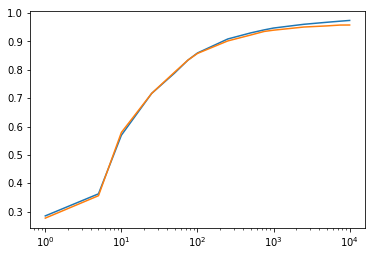

In [0]:
#Do non-LSA-ed version of the same thing
#Use  chi2 to get top k terms =
#n_terms = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
n_terms = [1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]

train_accs_ch2 = []
test_accs_ch2 = []

#print(type(test_accs))
for i in n_terms:
  ch2 = SelectKBest(chi2, k= i)
  dtm_train_ch2 = ch2.fit_transform(dtm_train, y_train)
  dtm_test_ch2 = ch2.transform(dtm_test)
  clf_ch2 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 1000, verbose = 3).fit(dtm_train_ch2, y_train)
  preds_Train_ch2 = clf_ch2.predict(dtm_train_ch2)
  preds_Test_ch2 = clf_ch2.predict(dtm_test_ch2)
  train_accs_ch2.append(np.trace(confusion_matrix(preds_Train_ch2, y_train))/len(y_train))
  test_accs_ch2.append(np.trace(confusion_matrix(preds_Test_ch2, y_test))/len(y_test))

  
print(train_accs_ch2)
print(test_accs_ch2)


plt.plot(n_terms, train_accs_ch2,n_terms, test_accs_ch2)
plt.xscale("log")

In [0]:
print(confusion_matrix(preds_Train_ch2, y_train))

confusion_matrix(preds_Test_ch2, y_test)
classification_report(preds_Test_ch2, y_test)

[[2104    3    1   10    2    1    3    0    1]
 [   1  380   10    0    1    0    0    0    0]
 [   6   29 2705    8   35   22   48   14    4]
 [  33    0    9 4006   12   20    5   15    1]
 [   2    0    3    4  795    0   17    0    1]
 [   0    0    3    5    1  701    4    8    1]
 [   0    1    0    0    0    0  352    0    0]
 [   0    0    1    2    0    0    0  493    0]
 [   4    2    6    2    1    1    6   27 3189]]


'              precision    recall  f1-score   support\n\n          FA       0.97      0.99      0.98       692\n         Geo       0.83      0.97      0.89       143\n        Hist       0.98      0.91      0.94       978\n         Lit       0.99      0.96      0.97      1368\n        Myth       0.92      0.97      0.94       257\n       Philo       0.87      0.95      0.91       242\n    Religion       0.71      0.97      0.82        99\n          SS       0.82      0.98      0.89       146\n         Sci       1.00      0.98      0.99      1116\n\n    accuracy                           0.96      5041\n   macro avg       0.90      0.96      0.93      5041\nweighted avg       0.96      0.96      0.96      5041\n'

In [0]:
#Look for some clustering with kmeans?
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Using LSA from above
#pca = PCA(n_components=3)
#pca_result = pca.fit_transform(df[feat_cols].values)df['pca-one'] = pca_result[:,0]
from sklearn.decomposition import SparsePCA
df = pd.DataFrame()
df['lsa-one'] = dtm_train_lsa[:,0]
df['lsa-two'] = dtm_train_lsa[:,1] 
df['lsa-three'] = dtm_train_lsa[:,2]

#df.head()


#plt.figure(figsize=(16,10))
#sns.scatterplot(
#    x="lsa-one", y="lsa-two",
#    hue= y_train,
#    palette=sns.color_palette("hls", 9),
#    data=df,
#    legend="full",
#    alpha=0.3
#)))

In [0]:

import plotly.express as px
#print([i for i in train_indices])
y_train_reset = y_train.reset_index()
answers_reset = qb['Answer']
answers_reset = answers_reset[[i for i in train_indices]]
answers_reset = answers_reset.reset_index()
print(answers_reset.head())

#print(answers_reset.head())
#answers_reset = answer_rest['Answer']
dtm_train_lsa_scale = StandardScaler().fit_transform(dtm_train_lsa)#
pca = PCA(n_components = 10)
pca_result=pca.fit_transform(dtm_train_lsa)
print('Explained variation per principal component: {}'.format(pca.fit(dtm_train_lsa).explained_variance_ratio_))
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1]
pca_df['pca-three'] = pca_result[:,2]
pca_df['Class'] = y_train_reset['Class']
pca_df['Answer'] = answers_reset['Answer']


print(pca_df.head())
fig = px.scatter_3d(pca_df, x='pca-one', y='pca-two', z='pca-three',
              color= 'Class', hover_name = 'Answer')

fig.update_traces(marker=dict(size=2), text = "Answer"),
fig.show()



   index                 Answer
0  16420          Invisible Man
1    395             Phosphorus
2   9348               Poseidon
3  17843  Infrared spectroscopy
4   1347         Abraham Maslow
Explained variation per principal component: [0.05735056 0.03816249 0.03516801 0.0309905  0.02757427 0.02586859
 0.02499415 0.02209647 0.02164306 0.02016804]
    pca-one   pca-two  pca-three Class                 Answer
0  0.311830  0.108811   0.189287   Lit          Invisible Man
1 -0.199002 -0.231276   0.074276   Sci             Phosphorus
2 -0.091876  0.049132   0.081056  Myth               Poseidon
3 -0.228751 -0.262764   0.083965   Sci  Infrared spectroscopy
4 -0.082160 -0.079135  -0.184011    SS         Abraham Maslow


In [0]:
y_test_reset = y_test.reset_index()
answers_reset = qb['Answer']
answers_reset = answers_reset[[i for i in test_indices]]
answers_reset = answers_reset.reset_index()
print(answers_reset.head())



dtm_test_lsa_scale = StandardScaler().fit_transform(dtm_test_lsa)#
pca = PCA(n_components = 10)
pca_result=pca.fit_transform(dtm_test_lsa)
print('Explained variation per principal component: {}'.format(pca.fit(dtm_test_lsa).explained_variance_ratio_))
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1]
pca_df['pca-three'] = pca_result[:,2]
pca_df['Class'] = y_test_reset['Class']
pca_df['Answer'] = answers_reset['Answer']


print(pca_df.head())
fig = px.scatter_3d(pca_df, x='pca-one', y='pca-two', z='pca-three',
              color= 'Class', hover_name = 'Answer')

fig.update_traces(marker=dict(size=2), text = "Answer"),
fig.show()





   index            Answer
0   3522         Noble gas
1   1593            Rabbit
2  14390          Thailand
3  14122  Oliver Goldsmith
4   6499        Inner core
Explained variation per principal component: [0.06300665 0.04259085 0.0384542  0.03315081 0.02965352 0.02718006
 0.02684916 0.02299918 0.02173884 0.0216293 ]
    pca-one   pca-two  pca-three Class            Answer
0 -0.200524 -0.139868   0.078409   Sci         Noble gas
1  0.121534 -0.001826   0.133837   Lit            Rabbit
2 -0.239379  0.336570   0.081558   Geo          Thailand
3  0.516137 -0.030881   0.232879   Lit  Oliver Goldsmith
4 -0.218025 -0.146192   0.040521   Sci        Inner core


In [0]:
#Just the scaled? LSA stuff

y_train_reset = y_train.reset_index()
answers_reset = qb['Answer']
answers_reset = answers_reset[[i for i in train_indices]]
answers_reset = answers_reset.reset_index()
print(answers_reset.head())



dtm_train_lsa_scale = StandardScaler().fit_transform(dtm_train_lsa)#
svd_viz = TruncatedSVD(n_components = 100)
svd_result=dtm_train_lsa
#print('Explained variation per principal component: {}'.format(pca.fit(dtm_train_lsa).explained_variance_ratio_))
svd_df = pd.DataFrame()
svd_df['svd-one'] = svd_result[:,0]
svd_df['svd-two'] = svd_result[:,1]
svd_df['svd-three'] = svd_result[:,2]
svd_df['Class'] = y_train_reset['Class']
svd_df['Answer'] = answers_reset['Answer']


print(svd_df.head())
fig = px.scatter_3d(svd_df, x='svd-one', y='svd-two', z='svd-three',
              color= 'Class', hover_name = 'Answer')

fig.update_traces(marker=dict(size=2), text = "Answer"),
fig.show()



   index                 Answer
0  16420          Invisible Man
1    395             Phosphorus
2   9348               Poseidon
3  17843  Infrared spectroscopy
4   1347         Abraham Maslow
    svd-one   svd-two  svd-three Class                 Answer
0  0.494049 -0.176063  -0.084382   Lit          Invisible Man
1  0.132474  0.209747  -0.080862   Sci             Phosphorus
2  0.164076  0.018167   0.051280  Myth               Poseidon
3  0.128559  0.228951  -0.088514   Sci  Infrared spectroscopy
4  0.275472  0.100923  -0.002220    SS         Abraham Maslow
